# Build regression model #
This notebook builds and evaluates the linear regression model of the data.

In [1]:
import pickle
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import feature_selection as f_select
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn import preprocessing
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV

#  from sklearn.feature_selection import RFECV
# >>> from sklearn.svm import SVR

from scipy import ndimage
import pprint as pp

%pylab inline
plt.style.use("ggplot")

Populating the interactive namespace from numpy and matplotlib


In [2]:
tdf0816 = pickle.load(open('tdf0816_model.p','rb'))

### Binary encode string features ###

In [3]:
def binary_encode(df,cols=['day','month','stage','week_day','year']):
    for col in cols:
        binary_matrix = patsy.dmatrix(col,data=df,return_type='dataframe')
        binary_matrix.drop('Intercept',axis=1,inplace=True)
        df = df.join(binary_matrix)
        df.drop(col,axis=1,inplace=True)
        
    return df

In [4]:
tdf0816 = binary_encode(tdf0816)

In [5]:
# drop start and finish columns now that there is coordinate data
tdf0816.drop(['start','finish'],axis=1,inplace=True)

In [6]:
pickle.dump(tdf0816,open('tdf0816_model_b.p','wb'))

### Normalize numerical data ###

In [7]:
tdf0816 = pickle.load(open('tdf0816_model_b.p','rb'))

In [8]:
# fix a last few null values
tdf0816.set_value(102,'winning_time',254.133333333);
tdf0816.set_value(104,'winning_time',163.133333333);
tdf0816.set_value(140,'start_lon',6.0134771);

In [9]:
tdf0816_norm=preprocessing.normalize(tdf0816,axis=0)
tdf0816_norm=pd.DataFrame(tdf0816_norm,columns=tdf0816.columns)

### Build model ###

In [10]:
def formula_builder(df,target):
    formula = target + ' ~ '
    for col in df.columns:
        if col == target:
            pass
        else:
            formula += col + ' + '
        
    formula = formula.rstrip(' + ')
    
    return formula

In [11]:
new_cols = {col: col.replace('[T.','_').rstrip(']') for col in tdf0816_norm.columns}
tdf0816_norm.rename(columns=new_cols, inplace=True)

In [12]:
tdf0816_norm.corr()['winning_time'].sort_values(ascending=False).head(10)

winning_time        1.000000
distance            0.941698
start_avg           0.588401
gradient_avg        0.536206
num_climbs          0.495926
num_sprints         0.490284
category_avg        0.483968
sprint_start_avg    0.444299
length_avg          0.360258
stage_12            0.136695
Name: winning_time, dtype: float64

### First Attempt ###

In [13]:
# select out variables with high correlation with winning time
corr_features = ['winning_time',
                 'distance',
                 'start_avg',
                 'gradient_avg',
                 'num_climbs',
                 'category_avg',
                 'num_sprints',
                 'sprint_start_avg']

In [14]:
# make dataframe for first model
tdf0816_0 = tdf0816_norm[corr_features].copy(deep=True).reset_index()
tdf0816_0.drop('index',axis=1,inplace=True)

In [15]:
tdf0816_0.head()

,winning_time,distance,start_avg,gradient_avg,num_climbs,category_avg,num_sprints,sprint_start_avg
0,0.067894,0.079443,0.140709,0.063778,0.021031,0.026829,0.046078,0.082599
1,0.006886,0.009542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.077843,0.082140,0.105072,0.066492,0.021031,0.026829,0.046078,0.098739
3,0.069874,0.071561,0.092397,0.086846,0.042061,0.040244,0.046078,0.087820
4,0.060679,0.068243,0.033432,0.069206,0.021031,0.026829,0.046078,0.082599


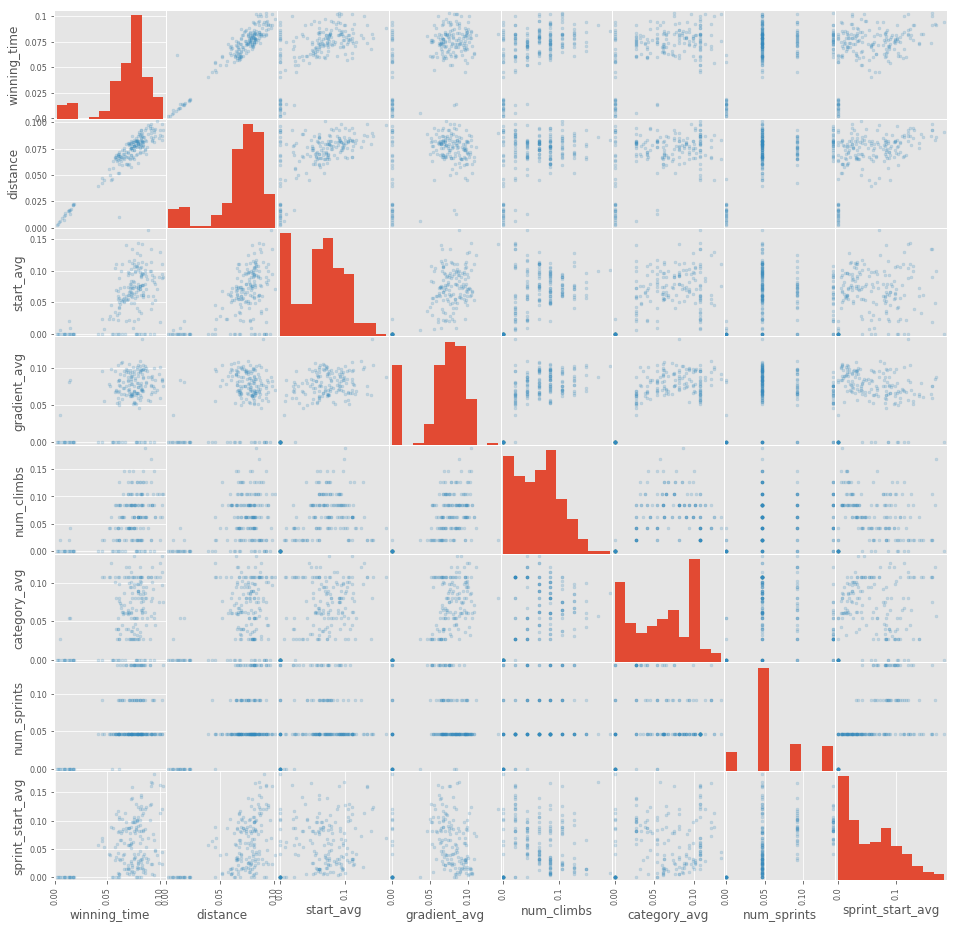

In [16]:
pd.scatter_matrix(tdf0816_0, alpha=0.2, figsize=(16, 16));

In [17]:
# Create your feature matrix (X) and target vector (y)
y_0, X_0 = patsy.dmatrices(formula_builder(tdf0816_0,'winning_time'), 
                       data=tdf0816_0, return_type="dataframe")

# Create your model
model_0 = sm.OLS(y_0, X_0)

# Fit your model to your training set
fit_0 = model_0.fit()

# Print summary statistics of the model's performance
fit_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           winning_time   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     251.2
Date:                Sat, 29 Apr 2017   Prob (F-statistic):           1.18e-89
Time:                        14:56:15   Log-Likelihood:                 671.49
No. Observations:                 189   AIC:                            -1327.
Df Residuals:                     181   BIC:                            -1301.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0013      0.002      0.757      0.450      -0.002       0.005
distance             0.9099      0.036     25.436      0.000       0.839       0.980
start_avg           -0.0400      0.021     -1.866      0.064      -0.082       0.002
gradient_avg         0.0327      0.031      1.042      0.299      -0.029       0.095
num_climbs           0.0615      0.018      3.449      0.001       0.026       0.097
category_avg         0.0293      0.021      1.406      0.162      -0.012       0.070
num_sprints         -0.0022      0.018     -0.121      0.903      -0.038       0.034
sprint_start_avg    -0.0027      0.015     -0.176      0.861      -0.033       0.028
==============================================================================
Omnibus:                      130.232   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1673.369
Skew:                           2.377   Prob(JB):                         0.00
Kurtosis:                      16.780   Cond. No.                         79.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The suprising thing about the data is that distance is still remarkably correlated with winning time despite so many large climbs in the Tour. I'm going to remove distance from the model for this reason.

### Second Attempt ###

In [18]:
# try again with distance removed
corr_features = ['winning_time',
                 'start_avg',
                 'gradient_avg',
                 'num_climbs',
                 'category_avg',
                 'num_sprints',
                 'sprint_start_avg']

In [19]:
# make dataframe for second model
tdf0816_1 = tdf0816_norm[corr_features].copy(deep=True).reset_index()
tdf0816_1.drop('index',axis=1,inplace=True)

In [20]:
# Create your feature matrix (X) and target vector (y)
y_1, X_1 = patsy.dmatrices(formula_builder(tdf0816_1,'winning_time'), 
                       data=tdf0816_1, return_type="dataframe")

# Create your model
model_1 = sm.OLS(y_1, X_1)

# Fit your model to your training set
fit_1 = model_1.fit()

# Print summary statistics of the model's performance
fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           winning_time   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     40.71
Date:                Sat, 29 Apr 2017   Prob (F-statistic):           3.30e-31
Time:                        14:56:21   Log-Likelihood:                 527.80
No. Observations:                 189   AIC:                            -1042.
Df Residuals:                     182   BIC:                            -1019.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0325      0.003     11.787      0.000       0.027       0.038
start_avg            0.1713      0.042      4.065      0.000       0.088       0.254
gradient_avg        -0.0621      0.066     -0.935      0.351      -0.193       0.069
num_climbs           0.1205      0.038      3.194      0.002       0.046       0.195
category_avg         0.1299      0.044      2.981      0.003       0.044       0.216
num_sprints          0.1610      0.037      4.387      0.000       0.089       0.233
sprint_start_avg     0.0953      0.032      3.014      0.003       0.033       0.158
==============================================================================
Omnibus:                        4.922   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                4.762
Skew:                           0.388   Prob(JB):                       0.0924
Kurtosis:                       3.040   Cond. No.                         69.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Going to drop gradient average because it is not significant as compared to the rest.

### Third Attempt ###

In [21]:
# try again with gradient average removed
sig_features = ['winning_time',
                 'start_avg',
                 'num_climbs',
                 'category_avg',
                 'num_sprints',
                 'sprint_start_avg']

In [22]:
# make dataframe for second model
tdf0816_2 = tdf0816_norm[sig_features].copy(deep=True).reset_index()
tdf0816_2.drop('index',axis=1,inplace=True)

In [23]:
# Create your feature matrix (X) and target vector (y)
y_2, X_2 = patsy.dmatrices(formula_builder(tdf0816_2,'winning_time'), 
                       data=tdf0816_2, return_type="dataframe")

# Create your model
model_2 = sm.OLS(y_2, X_2)

# Fit your model to your training set
fit_2 = model_2.fit()

# Print summary statistics of the model's performance
fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           winning_time   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     48.71
Date:                Sat, 29 Apr 2017   Prob (F-statistic):           6.88e-32
Time:                        14:56:29   Log-Likelihood:                 527.34
No. Observations:                 189   AIC:                            -1043.
Df Residuals:                     183   BIC:                            -1023.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0319      0.003     11.908      0.000       0.027       0.037
start_avg            0.1548      0.038      4.047      0.000       0.079       0.230
num_climbs           0.1057      0.034      3.088      0.002       0.038       0.173
category_avg         0.1069      0.036      2.972      0.003       0.036       0.178
num_sprints          0.1583      0.037      4.329      0.000       0.086       0.230
sprint_start_avg     0.0962      0.032      3.047      0.003       0.034       0.159
==============================================================================
Omnibus:                        6.100   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.869
Skew:                           0.426   Prob(JB):                       0.0532
Kurtosis:                       3.141   Cond. No.                         46.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All of the features are significant now and the r-squared is more reasonable.

### Evaluating the model ###

In [59]:
def kfold_ols(X,y):    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)
    kf = KFold(n_splits=3, shuffle=True)

    cross_val_results = {}
    counter = 0
    
    for train_small_idx, valid_idx in kf.split(X_train):
        cross_val_results[counter] = {}
        X_train_small = X_train.iloc[train_small_idx]
        y_train_small = y_train.iloc[train_small_idx]
        X_valid  = X_train.iloc[valid_idx]
        y_valid  = y_train.iloc[valid_idx]

        # Create your model
        model_train = sm.OLS(y_train_small, X_train_small)

        # Fit your model to your training set
        fit_train = model_train.fit()

        # Print summary statistics of the model's performance
        r2 = fit_train.rsquared
        adj_r2 = fit_train.rsquared_adj
        mse = mean_squared_error(y_valid, fit_train.predict(X_valid))
        cross_val_results[counter]['r2'] = r2
        cross_val_results[counter]['adj_r2'] = adj_r2
        cross_val_results[counter]['mse'] = mse
        
        counter += 1
    
    avg_r2 = sum([cross_val_results[c]['r2'] for c in range(len(cross_val_results))])/len(cross_val_results)
    avg_adj_r2 = sum([cross_val_results[c]['adj_r2'] for c in range(len(cross_val_results))])/len(cross_val_results)
    avg_mse = sum([cross_val_results[c]['mse'] for c in range(len(cross_val_results))])/len(cross_val_results)
    
    model = sm.OLS(y_train,X_train)
    fit = model.fit()
    
    whole_r2 = fit.rsquared
    whole_adj_r2 = fit.rsquared_adj
    whole_mse = mean_squared_error(y_test, fit.predict(X_test))
    
    print('Average CV r2: {:.3}'.format(avg_r2))
    print('Average CV adj-r2: {:.3}'.format(avg_adj_r2))
    print('Average CV MSE: {:.3e}'.format(avg_mse))
    print()
    print('Non-CV r2: {:.3}'.format(whole_r2))
    print('Non-CV adj-r2: {:.3}'.format(whole_adj_r2))
    print('Non-CV MSE: {:.3e}'.format(whole_mse))

In [60]:
kfold_ols(X_2,y_2)

Average CV r2: 0.615
Average CV adj-r2: 0.594
Average CV MSE: 2.209e-04

Non-CV r2: 0.616
Non-CV adj-r2: 0.601
Non-CV MSE: 2.560e-04


Cross-validation on slightly tempers non-CV scores; this is likely due to the data set's small size.

In [61]:
# use ENCV on model_2
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=1000)

encv_2 = ElasticNetCV()
encv_2.fit(X_2_train, y_2_train)

print('Elastic Net Cross-Validation r2: {:.3}'.format(encv_2.score(X_2_train, y_2_train)))
print('ENCV Alpha: {:.3e}'.format(encv_2.alpha_))

Elastic Net Cross-Validation r2: 0.616
ENCV Alpha: 1.154e-06


/Users/Chris/anaconda/envs/scienv3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Regularization does not improve the model.

In [68]:
tdf0816_ex_distance = tdf0816_norm.copy(deep=True)[[col for col in tdf0816_norm.columns if col != 'distance']]

In [69]:
new_cols = {col: col.replace('[T.','_').rstrip(']') for col in tdf0816_ex_distance.columns}
tdf0816_ex_distance.rename(columns=new_cols, inplace=True)

In [97]:
y, X = patsy.dmatrices(formula_builder(tdf0816_ex_distance,'winning_time'), 
                       data=tdf0816_ex_distance, return_type="dataframe")

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, np.array(y).ravel(), test_size=0.3)

selector = selector.fit(X_train,y_train)

X.columns[selector.ranking_ == 1]

Index(['category_avg', 'gradient_avg', 'num_climbs', 'num_sprints',
       'sprint_start_avg', 'start_avg', 'year_2011', 'year_2012', 'year_2013',
       'year_2014', 'year_2015', 'year_2016'],
      dtype='object')

Cross-validated recursive feature elimination corroborates the significance of the model's features.

### Plot results ###

In [103]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=1000)
model = sm.OLS(y_2_train,X_2_train)
fit = model.fit()
y_2_train_obs = y_2_train
y_2_train_predict = fit.predict(X_2_train)
y_2_test_obs = y_2_test
y_2_test_predict = fit.predict(X_2_test)

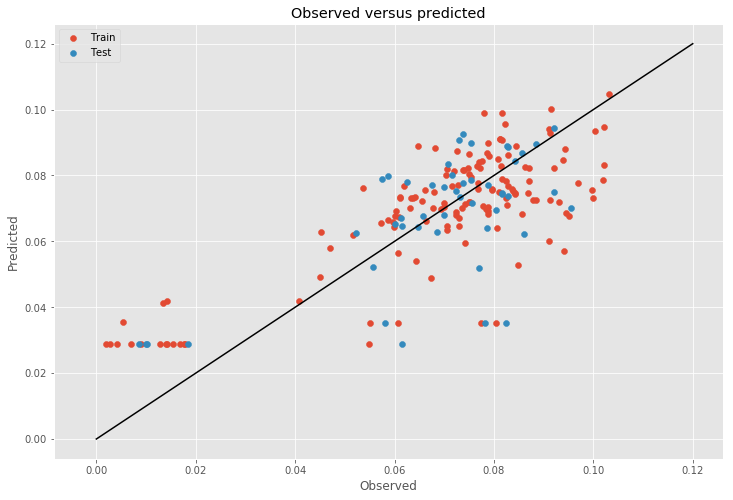

In [110]:
fig,ax = plt.subplots(figsize=(12,8))

ax.scatter(y_2_train_obs,y_2_train_predict,label='Train')
ax.scatter(y_2_test_obs,y_2_test_predict,label='Test')
ax.plot([0,.12],[0,.12],color='k')
ax.set(title='Observed versus predicted',
      xlabel='Observed',
      ylabel='Predicted');
ax.legend();